In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
from io import BytesIO
folder = "fashion-minst.zip" # folder containing the data

In [3]:
# Now we try to load the images and their corresponding labels into memory



def load_data(X, y, zip_path):
    with ZipFile(zip_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.endswith('.png'):
                # Extract the class label from the file path
                label = int(file_name.split('/')[-2])
                
                # Read the image data
                with zip_ref.open(file_name) as file:
                    img_data = BytesIO(file.read())
                    img = plt.imread(img_data)
                
                # Append image data and label
                X.append(img)
                
                # One-hot encode the label
                one_hot_label = [0] * 10
                one_hot_label[label] = 1
                y.append(one_hot_label)
        
        print(f"Loaded {len(X)} images")

# Usage
zip_path = "fashion-minst.zip"
X, y = [], []
load_data(X, y, zip_path)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print("Before reshaping")
print(X.shape, y.shape)
print(X[0].shape, y[0])

# Reshape the data
X = X[:, :, :, 0]  # Keep only one channel if it's grayscale
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])  # Flatten the images

print("After reshaping")
print(X.shape, y.shape)
print(X[0].shape, y[0])

# Normalize the input data
X = (X - np.mean(X)) / np.std(X)

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Now you can use X_train, y_train, X_val, and y_val with your neural network
print("Before reshaping")
print(X.shape, y.shape)
print(X[0], y[0])



Loaded 60000 images
Before reshaping
(60000, 28, 28, 4) (60000, 10)
(28, 28, 4) [1 0 0 0 0 0 0 0 0 0]
After reshaping
(60000, 784) (60000, 10)
(784,) [1 0 0 0 0 0 0 0 0 0]
Before reshaping
(60000, 784) (60000, 10)
[-8.1005293e-01 -8.1005293e-01 -8.1005293e-01 -8.1005293e-01
 -8.1005293e-01 -7.9894441e-01 -8.1005293e-01 -8.1005293e-01
 -8.1005293e-01 -8.1005293e-01 -3.6571157e-01  1.2783513e+00
  3.3412603e-01 -2.1019213e-01 -2.7684331e-01 -3.3238599e-01
  1.5638949e-01  1.0561807e+00  6.6738206e-01 -6.3231641e-01
 -8.1005293e-01 -8.1005293e-01 -8.1005293e-01 -8.1005293e-01
 -8.1005293e-01 -8.1005293e-01 -8.1005293e-01 -8.1005293e-01
 -8.1005293e-01 -8.1005293e-01 -8.1005293e-01 -7.9894441e-01
 -8.1005293e-01 -8.1005293e-01 -8.1005293e-01 -2.7684331e-01
  7.0070767e-01  1.6227160e+00  1.5893902e+00  1.7115842e+00
  1.8115609e+00  2.0226231e+00  2.0226231e+00  2.0226231e+00
  2.0226231e+00  1.6004989e+00  1.5782819e+00  2.0115144e+00
  1.7560184e+00  9.6731246e-01 -3.2127744e-01 -8.10052

In [4]:
class NN:
    def __init__(self, input_neurons, hidden_neurons, output_neurons, learning_rate, epochs):
        self.input_neurons = input_neurons
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.epochs = epochs
        self.lr = learning_rate

        self.wih = np.random.randn(hidden_neurons, input_neurons) * np.sqrt(2/input_neurons)
        self.bih = np.zeros((hidden_neurons, 1))

        self.who = np.random.randn(output_neurons, hidden_neurons) * np.sqrt(2/hidden_neurons)
        self.bho = np.zeros((output_neurons, 1))

    def relu(self, z):
        return z * (z > 0)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def relu_derivative(self, z):
        return 1 * (z > 0)

    def sigmoid_derivative(self, z):
        return z * (1 - z)

    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=0)

    def softmax_derivative(self, z):
        return z * (1 - z)

    def mean_squared_error(self, y, y_hat):
        return np.mean((y - y_hat) ** 2, axis=0)

    def cross_entropy_loss(self, y, y_hat):
        # Implement the cross entropy loss function here and return it
        # Keep the dimensions of the input in mind when writing the code
        return -np.sum(y * np.log(y_hat + 1e-8)) / y.shape[1]

    def mean_squared_error_derivative(self, y, y_hat):
        return y_hat - y

    def cross_entropy_derivative(self, y, y_hat):
        # Implement the cross entropy loss derivative function here and return it
        # Note: The derivative of the CEL is usually taken with respect to the softmax input not output
        return y_hat - y

    def forward(self, input_list):
        inputs = np.array(input_list, ndmin=2).T
        inputs = inputs - np.mean(inputs)
        
        # Hidden layer
        hidden_inputs = np.dot(self.wih, inputs) + self.bih
        hidden_outputs = self.relu(hidden_inputs)
        
        # Output layer
        final_inputs = np.dot(self.who, hidden_outputs) + self.bho
        final_outputs = self.softmax(final_inputs)
        
        return final_outputs

    def backprop(self, inputs_list, targets_list):
        inputs = np.array(inputs_list, ndmin=2).T
        inputs = inputs - np.mean(inputs)

        tj = np.array(targets_list, ndmin=2).T

        hidden_inputs = np.dot(self.wih, inputs) + self.bih
        hidden_outputs = self.relu(hidden_inputs)

        final_inputs = np.dot(self.who, hidden_outputs) + self.bho
        yj = self.softmax(final_inputs)

        # Calculating the loss - Using Cross Entropy Loss
        loss = self.cross_entropy_loss(tj, yj)

        # Output Layer
        dE_dzo = self.cross_entropy_derivative(tj, yj)

        dE_dwho = np.dot(dE_dzo, hidden_outputs.T) / hidden_outputs.shape[1]
        dE_dbho = np.mean(dE_dzo, axis=1, keepdims=True)
        
        self.who -= self.lr * dE_dwho
        self.bho -= self.lr * dE_dbho

        # Hidden Layer
        dE_dah = np.dot(self.who.T, dE_dzo)
        dE_dzh = dE_dah * self.relu_derivative(hidden_inputs)
        dE_dwih = np.dot(dE_dzh, inputs.T) / inputs.shape[1]
        dE_dbih = np.mean(dE_dzh, axis=1, keepdims=True)

        self.wih -= self.lr * dE_dwih
        self.bih -= self.lr * dE_dbih

        return np.mean(loss)

    def fit(self, inputs_list, targets_list, validation_data, validation_labels):
        train_loss = []
        val_loss = []
        for epoch in range(self.epochs):
            loss = self.backprop(inputs_list, targets_list)
            train_loss.append(loss)
            vloss = self.cross_entropy_loss(validation_labels.T, self.forward(validation_data))
            val_loss.append(np.mean(vloss)) 
            print(f"Epoch: {epoch}, Loss: {loss}, Val Loss: {val_loss[-1]}")

        return train_loss[1:], val_loss[:-1] 

    def predict(self, X):
        outputs = self.forward(X).T
        return outputs

Epoch: 0, Loss: 3.02504208910605, Val Loss: 2.137059443158498
Epoch: 1, Loss: 2.14324048841563, Val Loss: 1.7804028772096132
Epoch: 2, Loss: 1.7819623631149686, Val Loss: 1.5843513260712108
Epoch: 3, Loss: 1.5846058774542793, Val Loss: 1.4480144504067685
Epoch: 4, Loss: 1.4482645789291573, Val Loss: 1.345746550691459
Epoch: 5, Loss: 1.3462522279169218, Val Loss: 1.2660682968708417
Epoch: 6, Loss: 1.2669282553137677, Val Loss: 1.2021347417754351
Epoch: 7, Loss: 1.2034095458185718, Val Loss: 1.1495752781922246
Epoch: 8, Loss: 1.1512217029347016, Val Loss: 1.1054827236468727
Epoch: 9, Loss: 1.107446906560485, Val Loss: 1.067875716314517
Epoch: 10, Loss: 1.0700935500577744, Val Loss: 1.0353265359498829
Epoch: 11, Loss: 1.037763661442009, Val Loss: 1.0068400041452263
Epoch: 12, Loss: 1.0094582840857746, Val Loss: 0.9816260469374183
Epoch: 13, Loss: 0.984398450207609, Val Loss: 0.9590898004565549
Epoch: 14, Loss: 0.9620257843587864, Val Loss: 0.938806300559166
Epoch: 15, Loss: 0.941882643998

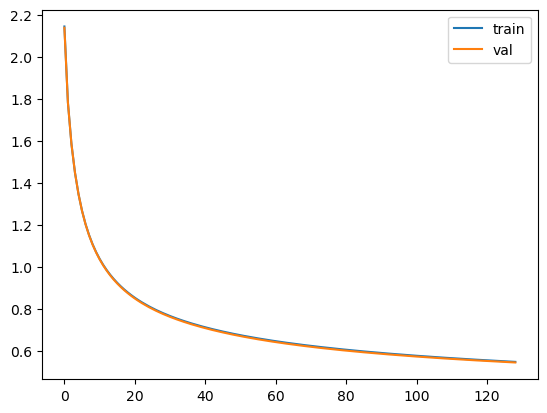

Accuracy: 0.7931666666666667


In [5]:
# This is where the class is used to train the model

# The parameters in the model are (input_neurons, hidden_neurons, output_neurons, learning_rate, epochs)
# These parameters aren't the right parameters, so tweak them to get the best results
# Around 70% accuracy is a good end goal (75% is great) but for the recruitment task, 60% is good enough

# [Q17] What are the parameters in the model and what do they mean?

fashion_mnist = NN(784, 160, 10, 0.03, 130)
p = np.random.permutation(len(X))
X, y = X[p], y[p]

# Splitting the data into training, validation and testing in the ratio 70:20:10
X_train, y_train = X[:int(0.7*len(X))], y[:int(0.7*len(X))]
X_val, y_val = X[int(0.7*len(X)):int(0.9*len(X))], y[int(0.7*len(X)):int(0.9*len(X))]
X_test, y_test = X[int(0.9*len(X)):], y[int(0.9*len(X)):]

# Training the model
train_loss,val_loss = fashion_mnist.fit(X_train, y_train,X_val,y_val)


# Plotting the loss
plt.plot(train_loss,label='train')
plt.plot(val_loss,label='val')
plt.legend()
plt.show()

y_pred = fashion_mnist.predict(X_test)

# [Q18] Why are we using argmax here? Why is this output different from the output of the model?
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print(f"Accuracy: {np.mean(y_pred == y_test)}")

In [6]:
print(f"Accuracy: {np.mean(y_pred == y_test)}")

Accuracy: 0.7931666666666667
